In [1]:
import matplotlib.pyplot as plt
import h5py
import torch
import numpy as np
from torchrl.record.loggers.csv import CSVLogger
from torchrl.record import VideoRecorder

In [7]:
filename = "../datasets/trajectory.rgb+segmentation.pd_ee_delta_pos.physx_cpu.h5"

In [8]:
f = h5py.File(filename, 'r')

In [9]:
print(f"Keys: {f.keys()}")

Keys: <KeysViewHDF5 ['traj_0', 'traj_1', 'traj_10', 'traj_100', 'traj_101', 'traj_102', 'traj_103', 'traj_104', 'traj_105', 'traj_106', 'traj_107', 'traj_108', 'traj_109', 'traj_11', 'traj_110', 'traj_111', 'traj_112', 'traj_113', 'traj_114', 'traj_115', 'traj_116', 'traj_117', 'traj_118', 'traj_119', 'traj_12', 'traj_120', 'traj_121', 'traj_122', 'traj_123', 'traj_124', 'traj_125', 'traj_126', 'traj_127', 'traj_128', 'traj_129', 'traj_13', 'traj_130', 'traj_131', 'traj_132', 'traj_133', 'traj_134', 'traj_135', 'traj_136', 'traj_137', 'traj_138', 'traj_139', 'traj_14', 'traj_140', 'traj_141', 'traj_142', 'traj_143', 'traj_144', 'traj_145', 'traj_146', 'traj_147', 'traj_148', 'traj_149', 'traj_15', 'traj_150', 'traj_151', 'traj_152', 'traj_153', 'traj_154', 'traj_155', 'traj_156', 'traj_157', 'traj_158', 'traj_159', 'traj_16', 'traj_160', 'traj_161', 'traj_162', 'traj_163', 'traj_164', 'traj_165', 'traj_166', 'traj_167', 'traj_168', 'traj_169', 'traj_17', 'traj_170', 'traj_171', 'traj_1

In [10]:
print(type(f['traj_0']))

<class 'h5py._hl.group.Group'>


In [11]:
f['traj_0'].keys()

<KeysViewHDF5 ['obs', 'actions', 'terminated', 'truncated', 'success', 'env_states']>

In [12]:
video_logger = CSVLogger(
    exp_name="../outputs/explore_trajectory",
    log_dir="./",
    video_format="mp4",
    video_fps=30,
)

video_recorder = VideoRecorder(
    logger=video_logger,
    in_keys=["pixels"],
    tag="trajectories_preview",
    skip=1,
    fps=30,
)

In [13]:
segments_colors = {obj_id: torch.randint(0, 256, (3,), dtype=torch.uint8) for obj_id in range(50)}

In [14]:
trajs = [0, 1, 2, 3, 4, 5, 6, 7, 8]

max_traj_length = f[list(f.keys())[0]]['obs']['sensor_data']['base_camera']['rgb'].shape[0] - 1

for traj_id in trajs:
    for t in range(max_traj_length):
        o_rgb = torch.as_tensor(f[f"traj_{traj_id}"]['obs']['sensor_data']['base_camera']['rgb'][t]).permute(2,0,1)
        o_seg = torch.as_tensor(f[f"traj_{traj_id}"]['obs']['sensor_data']['base_camera']['segmentation'][t]).permute(2,0,1)

        unique_seg_ids = torch.unique(o_seg)
        binary_masks = torch.stack([(o_seg == obj_id) for obj_id in unique_seg_ids], dim=0)

        H, W = binary_masks.shape[-2], binary_masks.shape[-1]

        frame_segs_colors = torch.stack([segments_colors[obj_id] for obj_id in unique_seg_ids.tolist()])

        object_colors = frame_segs_colors.view(-1, 3, 1, 1).expand(-1, 3, H, W)
        colored_segs = (binary_masks.to(torch.uint8) * object_colors).sum(dim=0)

        rgb_and_segs = torch.cat([o_rgb, colored_segs], dim=2)

        video_recorder._apply_transform(rgb_and_segs)

video_recorder.dump()

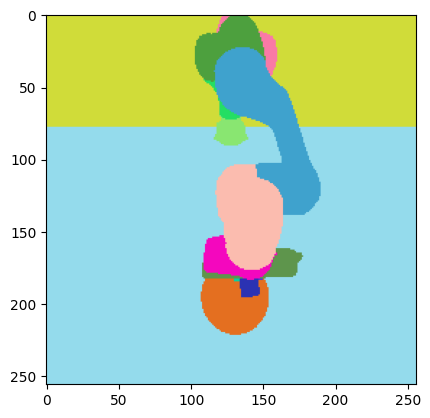

In [15]:
plt.imshow(colored_segs.permute(1,2,0).cpu().numpy())

In [16]:
rgb_segments = o_rgb * binary_masks
print(rgb_segments.shape)
print(rgb_segments.dtype)

torch.Size([14, 3, 256, 256])
torch.uint8


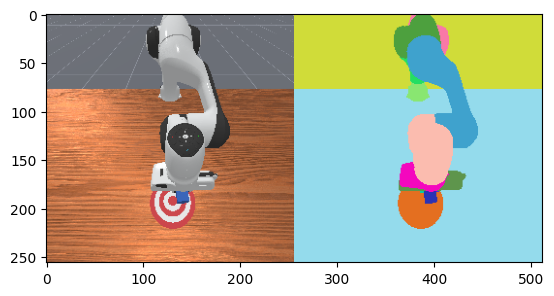

In [17]:
plt.imshow(torch.cat([o_rgb, colored_segs], dim=2).permute(1,2,0).cpu().numpy())

In [18]:
f.close()